In [2]:
#Importing libraries
import pandas as pd
import numpy as np
from scipy.optimize import fmin_slsqp
import matplotlib.pyplot as plt
import os
from pprint import pprint
import random

In [3]:
#Loading df
df = pd.read_csv('StrikerPerformance.csv') #skiprows = 1)
df = df.drop(df.loc[:,['age', 'current club', 'current league', 'foot', 'height', 'nationality', 'position']].head(0).columns, axis=1)
df = df[['name', 'games', 'minutes', 'assists', 'goals']]
df.head() #where xs are input vars and ys are output vars

#Loading df
# df = pd.read_csv('data-2018-09-24.csv') #skiprows = 1)
# f = df.drop(df.loc[:,['name', 'pft']].head(0).columns, axis=1)
# df.head() #where xs are input vars and ys are output vars

,name,games,minutes,assists,goals
0,Leroy Sané,39,2774,15,12
1,Raheem Sterling,36,2774,10,20
2,Bernardo Silva,44,2329,11,7
3,Sergio Agüero,37,2895,7,30
4,Gabriel Jesus,31,1766,4,11


In [4]:
#Save input, output and unit as separate numpy arrays
# inpt_df = df.iloc[:, 1:6]
# inpt_arr = np.array(inpt_df)
# outpt_df = df.iloc[:, 6:]
# outpt_arr = np.array(outpt_df)
# comp = np.array(df.iloc[:, 0])
# print(inpt_arr, outpt_arr, comp)

#Save input, output and unit as separate numpy arrays
inpt_df = df.iloc[:, [1,2]]
inpt_arr = np.array(inpt_df)
outpt_df = df.iloc[:, [3,4]]
outpt_arr = np.array(outpt_df)
comp = np.array(df.iloc[:, 0])
print(inpt_arr, outpt_arr, comp)

[[  39 2774]
 [  36 2774]
 [  44 2329]
 [  37 2895]
 [  31 1766]
 [  31 2464]
 [  38 1979]
 [  37 1903]
 [  42 3436]
 [  40 2128]
 [   7  187]
 [  43 2766]
 [  11  264]
 [  24  927]
 [  39 3222]
 [  28  958]
 [  40 2857]
 [  38 2252]
 [  44 2421]
 [  37 2249]
 [  32 1508]
 [  32 2501]
 [  16 1365]
 [  40 3165]
 [  16  799]
 [  23  662]
 [  30 2020]
 [  30 2707]
 [  29 2037]
 [  30 1604]
 [  11  545]
 [  23 1500]
 [  30 2081]
 [  40 2286]
 [  22 1145]
 [  28 1754]
 [  31 2390]
 [  10  548]
 [  28 1040]
 [  17  675]
 [  25 1383]
 [  32 1330]
 [  27 1773]
 [  21 1420]
 [  29 1727]
 [  14  812]
 [  31 2390]
 [  35 1993]
 [  32 2504]
 [  33 2703]
 [  23 1016]
 [  28 1392]
 [  29 2157]
 [  19  718]
 [  21 1831]
 [  31 2588]
 [   8  282]
 [  24 1974]
 [  30 2170]
 [  30 2259]
 [  12  631]
 [  21 1248]
 [  29 2284]
 [  17  755]
 [  30 2118]
 [  25 1292]
 [  33 2692]
 [  21 1207]
 [  28 1650]
 [  21 1396]
 [  28 1369]
 [  23 1483]
 [  12  369]
 [   4   43]
 [   5  311]
 [  28 1157]
 [  20 1003]

In [5]:
#Estimating efficient and non efficient units
class DEA(object):
    random.seed(5)
    def __init__(self, inputs, outputs):
        """
        Initialize the DEA object with input data
        n = number of entities (observations)
        m = number of inputs (variables, features)
        r = number of outputs
        :param inputs: inputs, n x m numpy array
        :param outputs: outputs, n x r numpy array
        :return: self
        """
        # supplied data
        self.inputs = inputs
        self.outputs = outputs
        # parameters
        self.n = inputs.shape[0]
        self.m = inputs.shape[1]
        self.r = outputs.shape[1]
        # iterators
        self.unit_ = range(self.n)
        self.input_ = range(self.m)
        self.output_ = range(self.r)
        # result arrays
        self.output_w = np.zeros((self.r, 1), dtype=np.float)  # output weights
        self.input_w = np.zeros((self.m, 1), dtype=np.float)  # input weights
        self.lambdas = np.zeros((self.n, 1), dtype=np.float)  # unit efficiencies
        self.efficiency = np.zeros_like(self.lambdas)  # thetas
        # names
        self.names = []

    def __efficiency(self, unit):
        """
        Efficiency function with already computed weights
        :param unit: which unit to compute for
        :return: efficiency
        """
        # compute efficiency
        denominator = np.dot(self.inputs, self.input_w)
        numerator = np.dot(self.outputs, self.output_w)
        return (numerator/denominator)[unit]

    def __target(self, x, unit):
        """
        Theta target function for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: theta
        """
        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        denominator = np.dot(self.inputs[unit], in_w)
        numerator = np.dot(self.outputs[unit], out_w)
        return numerator/denominator

    def __constraints(self, x, unit):
        """
        Constraints for optimization for one unit
        :param x: combined weights
        :param unit: which production unit to compute
        :return: array of constraints
        """
        in_w, out_w, lambdas = x[:self.m], x[self.m:(self.m+self.r)], x[(self.m+self.r):]  # unroll the weights
        constr = []  # init the constraint array
        # for each input, lambdas with inputs
        for input in self.input_:
            t = self.__target(x, unit)
            lhs = np.dot(self.inputs[:, input], lambdas)
            cons = t*self.inputs[unit, input] - lhs
            constr.append(cons)
        # for each output, lambdas with outputs
        for output in self.output_:
            lhs = np.dot(self.outputs[:, output], lambdas)
            cons = lhs - self.outputs[unit, output]
            constr.append(cons)
        # for each unit
        for u in self.unit_:
            constr.append(lambdas[u])
        return np.array(constr)

    def __optimize(self):
        """
        Optimization of the DEA model
        Use: http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.linprog.html
        A = coefficients in the constraints
        b = rhs of constraints
        c = coefficients of the target function
        :return:
        """
        d0 = self.m + self.r + self.n
        # iterate over units
        for unit in self.unit_:
            # weights
            x0 = np.random.rand(d0) - 0.5
            x0 = fmin_slsqp(self.__target, x0, f_ieqcons=self.__constraints, args=(unit,))
            # unroll weights
            self.input_w, self.output_w, self.lambdas = x0[:self.m], x0[self.m:(self.m+self.r)], x0[(self.m+self.r):]
            self.efficiency[unit] = self.__efficiency(unit)

    def name_units(self, names):
        """
        Provide names for units for presentation purposes
        :param names: a list of names, equal in length to the number of units
        :return: nothing
        """
        assert(self.n == len(names))
        self.names = names

    def fit(self):
        global not_efficient, alls
        """
        Optimize the dataset, generate basic table
        :return: table
        """
        self.__optimize()  # optimize
        print("---------------------------\n")       

        efficient = {}
        not_efficient = {} 
        alls = {}
        for n, eff in enumerate(self.efficiency): 
            if eff >= 1.:
                efficient.update({self.names[n]: eff[0]}) 
            else:
                not_efficient.update({self.names[n]: eff[0]})
        for n, eff in enumerate(self.efficiency): 
            alls.update({self.names[n]: eff[0]})              
        print("Efficient units:")     
        print(str(efficient).replace("{","").replace("}", ""))       
        print("\n")    
        print("Inefficient units:")
        print(str(not_efficient).replace("{","").replace("}", ""))  

def save_results(dataframe):  
    df_results = pd.DataFrame([]) 
    df_results = df_results.append(not_efficient, ignore_index = True).T
    df_results = df_results.reset_index()
    df_results.columns = ['name', 'efficiency']    
    dataframe = dataframe.merge(df_results)
    return dataframe      

def save_results_complete(dataframe):    
    df_results_complete = pd.DataFrame([]) 
    df_results_complete = df_results_complete.append(alls, ignore_index = True).T
    df_results_complete = df_results_complete.reset_index()
    df_results_complete.columns = ['name', 'efficiency']    
    dataframe_complete = dataframe.merge(df_results_complete)
    return dataframe_complete        

dea = DEA(inpt_arr, outpt_arr)
dea.name_units(comp)
dea.fit()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0000000305059942
            Iterations: 15
            Function evaluations: 1867
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8860153262497033
            Iterations: 11
            Function evaluations: 1452
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7322469047502181
            Iterations: 9
            Function evaluations: 1186
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9906296221285873
            Iterations: 10
            Function evaluations: 1318
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6185683596070244
            Iterations: 19
            F

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.818285714288581
            Iterations: 14
            Function evaluations: 1717
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2304913262300012
            Iterations: 7
            Function evaluations: 934
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6206030545086038
            Iterations: 14
            Function evaluations: 1714
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.0154131276487335
            Iterations: 6
            Function evaluations: 811
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.20812102502056698
            Iterations: 10
            Funct

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0647685444433828
            Iterations: 7
            Function evaluations: 943
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.17654517995734614
            Iterations: 12
            Function evaluations: 1589
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6311243772487839
            Iterations: 7
            Function evaluations: 924
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.32224022810957453
            Iterations: 12
            Function evaluations: 1608
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3008211438571928
            Iterations: 11
            Fun

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.29632309192213374
            Iterations: 7
            Function evaluations: 938
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0735280693366744
            Iterations: 10
            Function evaluations: 1317
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2280013502620922
            Iterations: 10
            Function evaluations: 1328
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.14309781037381322
            Iterations: 12
            Function evaluations: 1588
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.46004443740578743
            Iterations: 6
            

In [10]:
df_ineff = save_results(df)
df_complete = save_results_complete(df)
df_complete.to_csv('resultStrikerPerformance', index=False)
df_complete.head()

,name,games,minutes,assists,goals,efficiency
0,Leroy Sané,39,2774,15,12,1.000000
1,Raheem Sterling,36,2774,10,20,0.886015
2,Bernardo Silva,44,2329,11,7,0.732247
3,Sergio Agüero,37,2895,7,30,0.990630
4,Gabriel Jesus,31,1766,4,11,0.618568


In [7]:
#Estimating the improvement options - input oriented
heading = list(df_ineff.iloc[:, 1:3])

inter = []
for c in df_ineff.iloc[:, 1:3].columns:
    inter.append(df_ineff[c].multiply((1- df_ineff.iloc[:,-1])))
    df_improvement = round(pd.concat(inter, axis = 1),1)
    df_improvement = df_improvement.rename(columns = dict(zip(df_improvement.columns, heading)))
df_improvement  = pd.concat([df_improvement,df_ineff[['name']]], axis = 1)
df_improvement.head()

,games,minutes,name
0,4.1,316.2,Raheem Sterling
1,11.8,623.6,Bernardo Silva
2,0.3,27.1,Sergio Agüero
3,11.8,673.6,Gabriel Jesus
4,13.3,1060.0,Alexis Sánchez


In [8]:
#Estimating the improvement options - output oriented
heading_output = list(df.iloc[:, 3:5])

inter_out = []
for c in df.iloc[:, 3:5].columns:
    inter_out.append(df[c].multiply((1- df.iloc[:,-1])/df.iloc[:,-1]).add(df[c]))
    df_improvement_outpt = round(pd.concat(inter_out, axis = 1),1)
    df_improvement_outpt = df_improvement_outpt.rename(columns = dict(zip(df_improvement_outpt.columns, heading_output)))
df_improvement_outpt  = pd.concat([df_improvement_outpt,df[['name']]], axis = 1)
df_improvement_outpt.head()

,assists,goals,name
0,1.2,1.0,Leroy Sané
1,0.5,1.0,Raheem Sterling
2,1.6,1.0,Bernardo Silva
3,0.2,1.0,Sergio Agüero
4,0.4,1.0,Gabriel Jesus


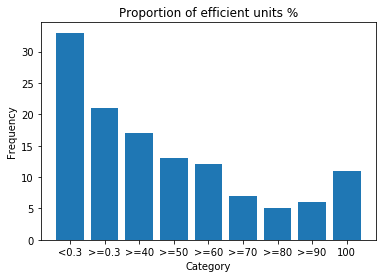

In [9]:
#Assigning lables depending on the efficiency score
def classification(x):
    """The function assings lables depending on the efficiency score a unit falls into"""
    for u in x:
        if u >= 1.0 : return '100'
        elif u >= 0.9: return '>=90'
        elif u >= 0.8: return '>=80'
        elif u >= 0.7: return '>=70'
        elif u >= 0.6: return '>=60'
        elif u >=0.5: return '>=50'
        elif u >=0.4: return '>=40'
        elif u >= 0.3: return '>=0.3'
        else: return '<0.3'
df_complete['category'] =  df_complete[['efficiency']].apply(classification, axis = 1)
# df_complete

#Creating the frequency table
df_freq = df_complete.groupby('category').count().reset_index()
# df_freq
categories = ['<0.3', '>=0.3', '>=40', '>=50', '>=60', '>=70', '>=80', '>=90', '100']
# categories
#Ploting the distribution graph
mapping = {category: i for i, category in enumerate(categories)}
# mapping
key = df_freq['category'].map(mapping)
# key
df_freq = df_freq.iloc[key.argsort()]
# df_freq

# Draw the bar chart
plt.bar(df_freq['category'], df_freq['efficiency'], tick_label=categories)
plt.title('Proportion of efficient units %')
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.show()